**Load the Saved Model**

In [ ]:
from google.colab import files
saved_model = files.upload()

Saving model.pth to model.pth


In [ ]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

# Define same model structure
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet_model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 10)
)

# Compile the model again (same as before)
my_model = torch.compile(resnet_model)

# Load the state_dict
my_model.load_state_dict(torch.load("model.pth", map_location="cpu"))

my_model.eval()

OptimizedModule(
  (_orig_mod): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


**Load the test data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/EuroSAT_splitted/test /content/

Mounted at /content/drive


**Custom dataset**

In [ ]:
import os
import glob
import torch
from torch.utils.data import Dataset
from PIL import Image

DATA_LABELS = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial",
               "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"]

class MyDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for l_idx, label in enumerate(DATA_LABELS):
            paths = glob.glob(os.path.join(data_dir, label, '*.jpg'))
            for path in paths:
                self.image_paths.append(path)
                self.labels.append(l_idx)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx]).long()
        return image, label

    def __len__(self):
        return len(self.image_paths)

**Preprocessing**

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

random_trans224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_path = "/content/test"
test_data = MyDataset(test_path, transform=random_trans224)
test_loader = DataLoader(test_data, batch_size=32)
test_N = len(test_loader.dataset)

**Accuracy function**

In [ ]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

**Test function**

In [ ]:
def test(model, test_loader, test_N, loss_function):
    model.eval()
    total_loss = 0
    total_correct = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = loss_function(output, y)
            total_loss += loss.item()

            # Accuracy
            pred = output.argmax(dim=1)
            correct = pred.eq(y).sum().item()
            total_correct += correct

    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / test_N

    print(f"Test - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

import torch.nn as nn
loss_function = nn.CrossEntropyLoss()

test(my_model, test_loader, test_N, loss_function)

Test - Loss: 0.0742, Accuracy: 0.9761


(0.07416491454434407, 0.9760671107821367)

**Image Prediction function**

In [ ]:
from google.colab import files
from PIL import Image
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
import torch

def predict_uploaded_image(model, transform, class_names, device):
    # Upload image
    uploaded = files.upload()
    img_path = list(uploaded.keys())[0]

    # Open and show image
    image = Image.open(img_path).convert("RGB")
    plt.imshow(image)
    plt.axis('off')
    plt.title("Uploaded Image")
    plt.show()

    # Transform and prepare tensor
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Model prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred_class_idx = output.argmax(dim=1).item()

    print("Predicted class:", class_names[pred_class_idx])
    return pred_class_idx

# Example usage:
# pred = predict_uploaded_image(my_model, random_trans224, DATA_LABELS, device)

Saving TESTSeaLake.jpg to TESTSeaLake.jpg


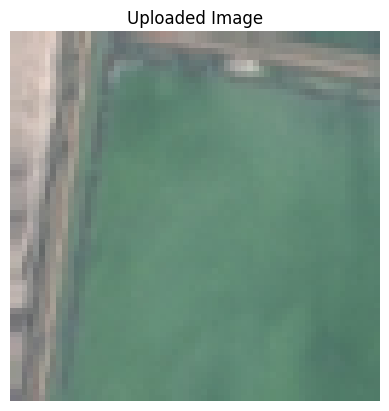

Predicted class: SeaLake


In [ ]:
pred = predict_uploaded_image(my_model, random_trans224, DATA_LABELS, device)